# Joint probability experiment

In [1]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")
library(repr)
options(repr.plot.width=8, repr.plot.height=5.5)

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Skipping install of 'ptdalgorithms' from a local remote, the SHA1 (1.0.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# remove.packages("ptdalgorithms")

In [4]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
Rcpp::sourceCpp("./cpp/coalescent.cpp")

In [8]:
source("plot_functions.R")

In [9]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial"))

In [10]:
# p <- ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species)) + despine

# ggplotly(width=600, height=400)

In [11]:
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17)) 

options(repr.plot.width=10, repr.plot.height=7)

# ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species), size=5, alpha=0.5) + scale_color_brewer(palette="Set1") + despine

## Section from Tobias paper that was taken out

We note that, although computationally infeasible in most situations, the joint distribution function of multivariate discrete phase-type distributions can also be described by such a recursive algorithm (and time-inhomogeneous multivariate discrete phase-type distributions as seen later). Instead of defining the probability of the system visiting a vertex at time $t$, we instead keep track of both the visited vertex and the accumulated reward at time $t$. Consider an $\ell+1$-dimensional table for an $\ell$-dimensional multivariate discrete phase-type distribution. The first dimension has $|V|$ entries, one for each vertex. The other dimensions has entries corresponding to the natural numbers from $0$ to $k$ where $k$ is sufficiently large, such that for a given distribution function of specified accumulated rewards $\vec{s}$, $F_{\vec{s}}$, then $k$ is larger or equal to any entry in $\vec{s}$. At a time $t$ an entry in the table corresponds to the probability of the system being in a specific state, and having accumulated a specific vector of integer rewards corresponding to the other dimensions. If we have accumulated more than any of the rewards $\vec{s}$, we assign probability zero to the entry in the table before the next time step. Assuming we have removed the vertices with zero rewards in all dimensions (e.g. using the reward transformation algorithm), then all time steps will increase at least one entry in the reward accumulation, and after a finite number of steps all entries will either be zero, or for the absorbing vertices the total probability of the system having reached an absorbing state with less than or equal to the rewards $\vec{s}$, which is the definition of the cumulative distribution function for the multivariate discrete phase-type distribution.

## Generate standard coalescent state space

If you want to generate the state space:

In [12]:
standard_coalescent <- function(n) {
    
    # n <- 4
      
    state_vector_length <- n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

In [ ]:
make_discrete <- function(mutation_graph, mutation_rate) {
    # Takes a graph for a continuous distribution and turns
    # it into a descrete one (inplace). Returns a matrix of
    # rewards for computing marginal moments

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(mutation_graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    rewards = t(rewards)
    return(rewards)
}

# # self-transition rate:
# mutation_rate <- 1e-8

# # clone graph to get one to modify:
# mutation_graph <- clone_graph(graph)

# # add auxilliary states, normalize and return reward matrix:
# rewards <- make_discrete(mutation_graph, mutation_rate)

# # for plotting the new graph
# gam <- graph_as_matrix(mutation_graph)

## State space for joint proability computation

Generate coalescent state space like normal with the following modifications

- Change state space from (4, 0, 0, 0) to (4, 0, 0, 0, t1, t2, t3, t4). The last extra "ton" states keep track of the number accumulated mutations of each kind. We simply double the state vector so we keep track of the counts lineages with descendants, but also the counts of mutations happened on such lineages.
- Each state can mutate to accumulate a "ton" in accordance with its state vector. E.g., a `(4, 0, 0, 0, 0, 0, 0, 0)` state can only make singletons,  a `(2, 1, 0, 0, 0, 0, 0, 0)` state can only make singletons and doubletons.
- A mutation event is a transition to a siter state E.g., `(4, 0, 0, 0, 0, 0, 0, 0) -> (4, 0, 0, 0, 1, 0, 0, 0)`
- The ton counts have a maximum value (base-1). If this value is reached, the mutation transition instead leads to a trash state with an infinite self loop. The transitions to trash represents the part of the deficient PDF not covered because we only run up to a max nr of tons.

## Reward transform

- Convert the last half of each state (with ton counts) to numbers in some base.
- Use these for reward transformation.
- Compute PDF for t <- 1:sample_size^(base-1)
- Convert each time t back to the corresponding ton vector and associate it with the probability
- group by two tons and sum probs in groups to get all pairwise combinations for a joint probability matrix.


## Sanity checks

- If we compute the marginal probabilities for each ton it should be close to the SFS (appart from the deficit in the PDF)

In [312]:
ndigits <- function(x){
  y <- floor(abs(x))
  if(y != 0){
    floor(log10(y)) + 1
  } else {
    1
  }
}
rev_number=function(n){
    m=as.integer(rev(strsplit(as.character(n),"")))
    if (m==rev(m)) print("reversed number")
}
forth <- function(vec, base) {
    # return( as.integer( c(vec %*%  (base ^ rev(seq_along(vec)) / base)) ) )
    # return( as.integer( c(vec %*%  (base ^ (seq_along(vec)) / base)) ) )
    # return( c(vec %*%  (base ^ (rev(seq_along(vec))) / base)) ) 
    return( c(vec %*%  (base ^ (seq_along(vec)) / base)) ) 
}
back <- function(x, base, state_length) {
    # x <- as.integer(rev(paste(x, collapse='')))
    # x <- floor(as.numeric(rev(paste(x, collapse=''))))
    vec <- c()

    for (i in 1:state_length) {
        # if (x > 0) {
            vec <- c(x %% (base), vec)
            x <- x %/% (base)
        # }
    }

    # while (x > 0) {
    #     vec <- c(x %% (base), vec)
    #     x <- x %/% (base)
    # }
    
    # for (i in 1:ndigits(x)) {
    #     if (x > 0) {
    #         vec <- c(x %% (base), vec)
    #         x <- x %/% (base)
    #     }
    # }
    vec <- as.integer(vec)
    return( rev(c(rep(0, state_length-length(vec)), vec) ))
    # return( c(rep(0, state_length-length(vec)), vec) )
}
vec <- c(1, 2, 0)
base <- max(vec)+1
state_length <- length(vec)
print(vec)
f <- forth(vec, base)
print(f)
b <- back(f, base, state_length)
print(b)
b <- c(rep(0, length(vec)-length(b)), b)
print(b)

[1] 1 2 0
[1] 7
[1] 1 2 0
[1] 1 2 0


In [454]:
discrete_coalescent <- function(n, mutation_rate, max_tons) {
    
    state_vector_length <- n + n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2

    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

      # skip if we only have one lineage left or if this is a trash state
      if (sum(vertex$state[1:n]) <= 1) {
        index <- index + 1
        next
      }
        
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate
            )
        }
      }

      # mutations
      trash_rate <- 0 
      for (i in 1:n)  {
        rate <- vertex$state[i] * mutation_rate
        nr_tons <- child_state[n+i]
        if (rate > 0) {
            if (nr_tons < max_tons) {
              child_state <- state
              child_state[n+i] <- child_state[i+n] + 1
              add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
            } else {
              trash_rate <- trash_rate + rate
            }
        }
      }
      if (trash_rate > 0) {
        add_edge(vertex, find_or_create_vertex(graph, rep(0, state_vector_length)), trash_rate)
      }

      index <- index + 1
    }
    trash_vertex <- find_or_create_vertex(graph, rep(0, state_vector_length))
    trash_loop_vertex <- create_vertex(graph, rep(0, state_vector_length))
    add_edge(trash_vertex, trash_loop_vertex, 1)
    add_edge(trash_loop_vertex, trash_vertex, 1)
    
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

sample_size <- 3
# mutation_rate <- 20000 * 31 * 5e-10 # 0.00031
mutation_rate <- 20
max_tons <- 3
base <- max_tons + 1
graph <- discrete_coalescent(sample_size, mutation_rate, max_tons)
gam <- graph_as_matrix(graph)
#gam

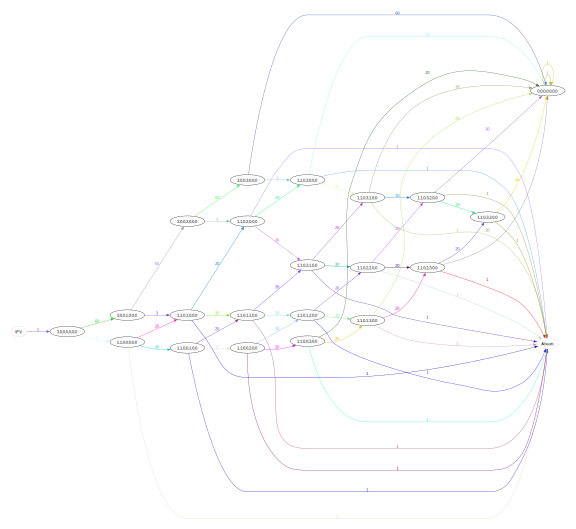

In [455]:
plot_graph(gam, #subgraphs=TRUE, 
           rainbow=TRUE,
           size=c(8, 8), 
           align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           # subgraphfun=function(state) paste(state[-length(state)], collapse="")
           )

In [456]:
rewards <- states(graph)[, (sample_size+1):(2*sample_size)]

In [457]:
multi_rewards <- apply(rewards, 1, forth, base=base)
multi_rewards

[1]  0  0  0  1  0  1  4  2  1  2  5  4  8  3  2  3  6  5  9  8 12  0  3  7  6
[26] 10  9 13 12  7 11 10 14 13 11 15 14 15  0

In [458]:
rew_graph <- reward_transform(graph, multi_rewards)
df <- data.frame(t=seq(0, base^(sample_size-1), 1))
# df <- data.frame(t=seq(0, length(multi_rewards), 1))
df['prob'] <- sapply(df$t, function (t) dph(t, rew_graph))
tail(df)

,t,prob
,<dbl>,<dbl>
12,11,9.143814e-13
13,12,6.156143e-14
14,13,4.114123e-15
15,14,2.733224e-16
16,15,1.807204e-17
17,16,1.190343e-18


In [459]:
sum(df$prob * df$t)

[1] 0.09037773

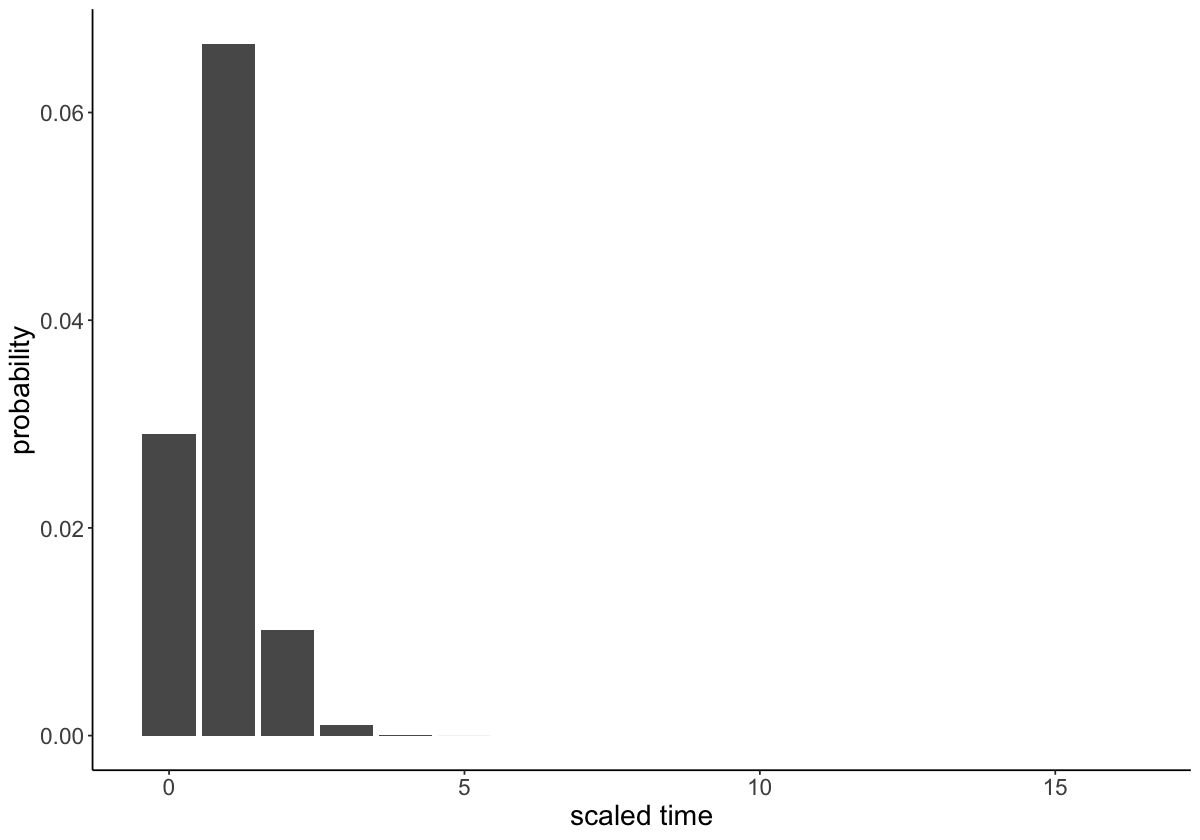

In [460]:
df %>% ggplot(aes(x=t, y=prob)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine

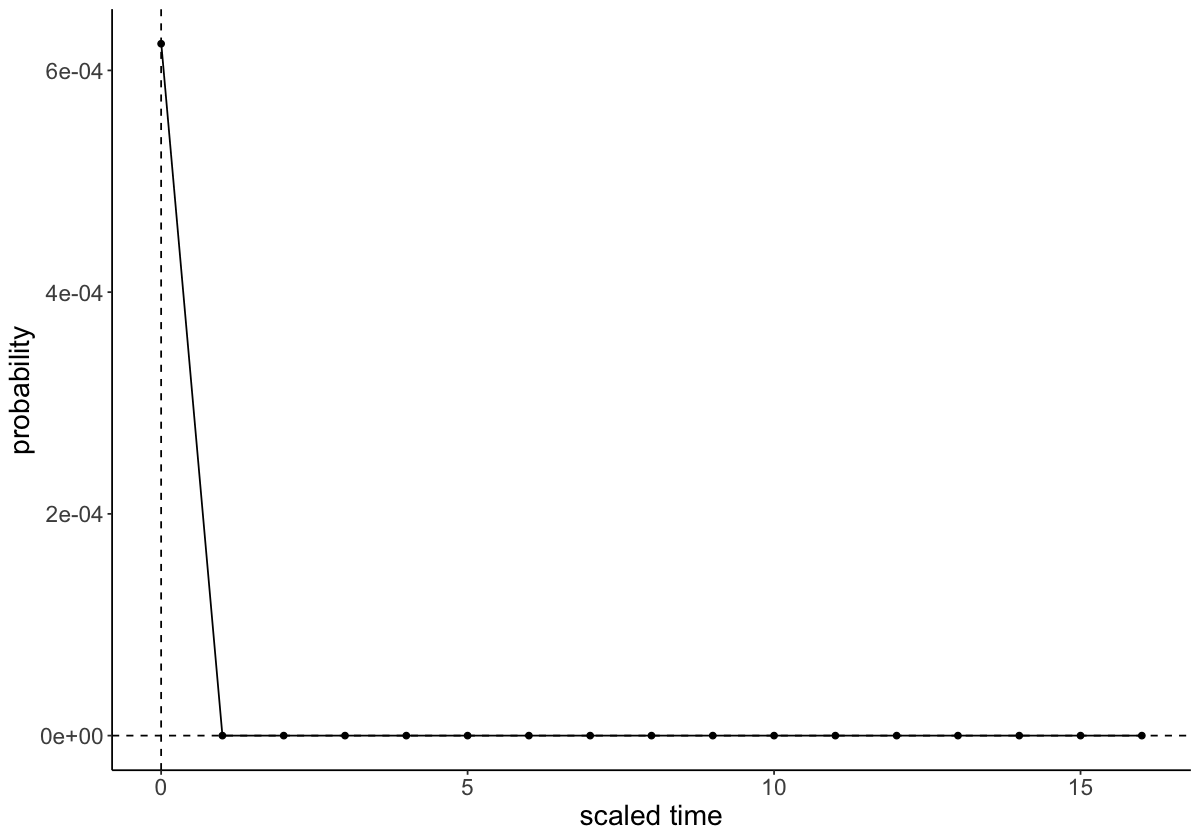

In [410]:
df %>% ggplot(aes(x=t, y=prob)) + 
    geom_point(color='black') + 
    geom_line(color='black') + 
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_vline(xintercept = 0, linetype = "dashed") +
    labs(x='scaled time', y='probability') + 
    despine + scale_color_viridis(discrete = TRUE)

In [411]:
x <- lapply(df$t, back, base=base, state_length=sample_size)

In [397]:
#x <- lapply(x, rev)
m <- do.call(rbind, x)
multi_df <- data.frame(m)
multi_df['prob'] = df$prob
head(multi_df)

,X1,X2,X3,prob
,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0.054112554
2,1,0,0,0.109755650
3,2,0,0,0.054979938
4,3,0,0,0.022181355
5,0,1,0,0.007689873
6,1,1,0,0.002436337


In [398]:
tail(multi_df)

,X1,X2,X3,prob
,<dbl>,<dbl>,<dbl>,<dbl>
12,3,2,0,1.176081e-06
13,0,3,0,3.112535e-07
14,1,3,0,8.165916e-08
15,2,3,0,2.126535e-08
16,3,3,0,5.502609e-09
17,0,0,1,1.415997e-09


**Sanity check:** the marginal summed probabilities should sum to the SFS.

In [399]:
i <- 0
for (ton in c('X1', 'X2') ) {
# for (ton in c('X1', 'X2', 'X3', 'X4', 'X5', 'X6') ) {
    i <- i + 1
    mean_tons <- sum(multi_df[ton] * multi_df$prob)
    cat(mean_tons, '\t', mean_tons / mut_rate * i, '\n')
}

0.2908147 	 29081471 
0.01122904 	 2245808 


In [400]:
# plot_df <- multi_df %>% group_by(X3, X4) %>% summarise(joint_prob = sum(prob))# %>% filter(X3 > 0 & X4 > 0)
# head(plot_df)
plot_df <- multi_df %>% group_by(X1, X2) %>% summarise(joint_prob = sum(prob))
plot_df[,-ncol(plot_df)] <- lapply(plot_df[,-ncol(plot_df)], as.factor)
head(plot_df)

`summarise()` has grouped output by 'X1'. You can override using the `.groups` argument.


X1,X2,joint_prob
<fct>,<fct>,<dbl>
0,0,5.411256e-02
0,1,7.689873e-03
0,2,5.903697e-05
0,3,3.112535e-07
1,0,1.097557e-01
1,1,2.436337e-03


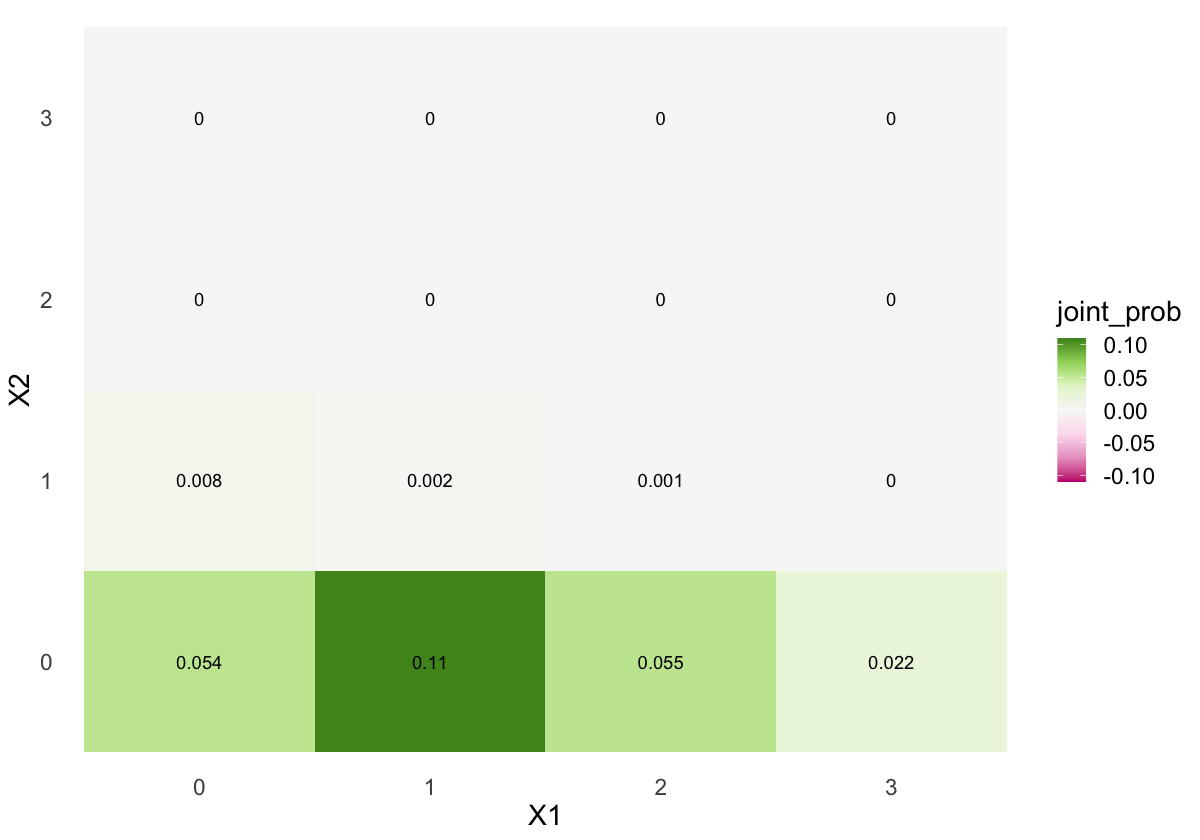

In [401]:
ggplot(plot_df, aes(x=X1, y=X2)) +
    geom_tile(aes(fill = joint_prob)) + 
    geom_text(aes(label = round(joint_prob, 3))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(plot_df$joint_prob)) * c(-1, 1)
                    ) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

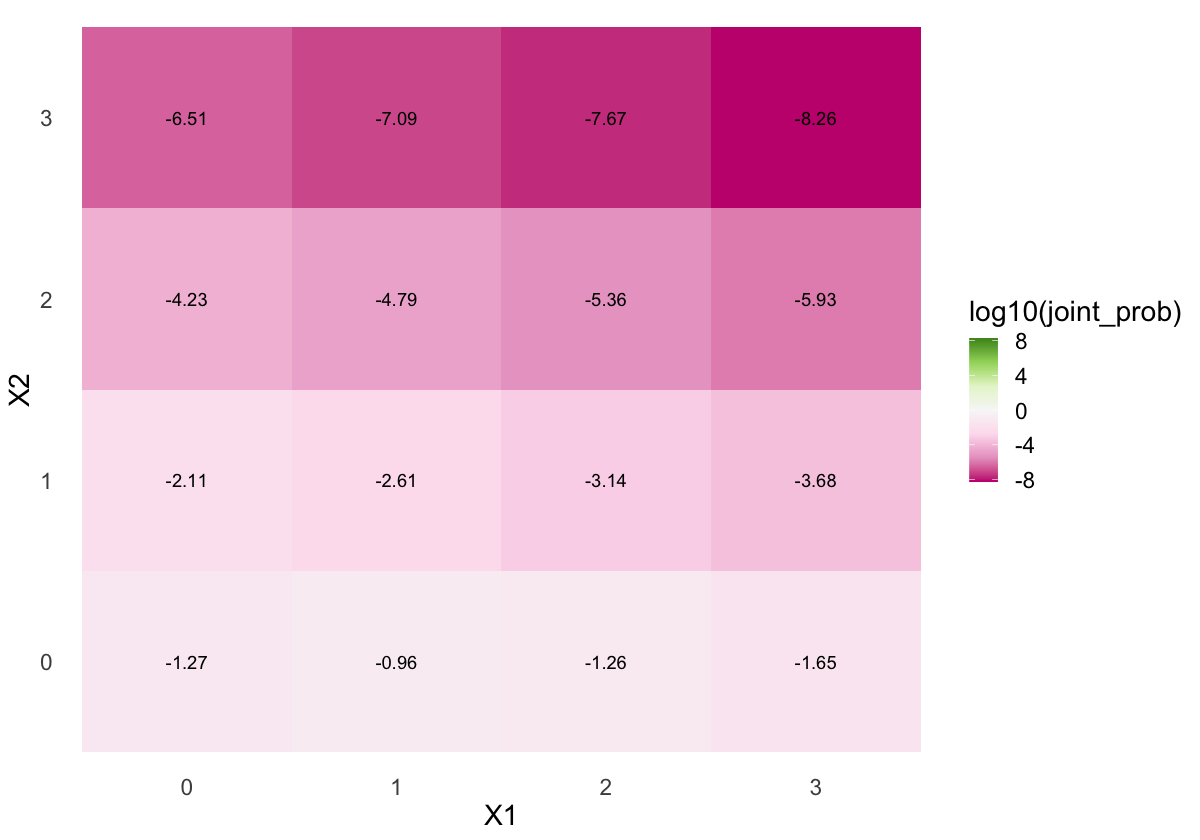

In [402]:
ggplot(plot_df, aes(x=X1, y=X2)) +
    geom_tile(aes(fill = log10(joint_prob))) + 
    geom_text(aes(label = round(log10(joint_prob), 2))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(log10(plot_df$joint_prob))) * c(-1, 1)
                    ) +
theme_minimal() +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))


# Previous attempt

In [42]:
sample_size <- 7
mut_rate <- 1e-8
graph <- standard_coalescent(sample_size)
rewards <- make_discrete(graph, mut_rate)
# rewards <- t(states(graph))
rewards

ERROR: Error in make_discrete(graph, mut_rate): could not find function "make_discrete"


In [20]:
gam <- graph_as_matrix(graph)
gam

0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0


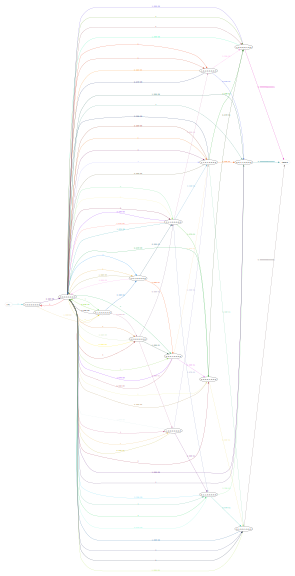

In [21]:
plot_graph(gam, #subgraphs=TRUE, 
           rainbow=TRUE,
           size=c(8, 8), 
           align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           # subgraphfun=function(state) paste(state[-length(state)], collapse="")
           )

In [22]:
base <- 5
multi_rewards <- apply(rewards, 2, forth, base=base)
multi_rewards

[1]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[16]    0    1    1    5    1    5    1   25    1    5    1    5   25    1  125
[31]    5   25    1    5  125    1   25    1  625   25  125    5  625    1 3125

In [23]:
g <- reward_transform(graph, multi_rewards)
df <- data.frame(t=seq(0, base^(sample_size-1), 1))
df['prob'] <- sapply(df$t, function (t) dph(t, g))
head(df)

,t,prob
,<dbl>,<dbl>
1,0,2.231411e-08
2,1,9.302290e-09
3,2,4.340539e-09
4,3,2.376036e-09
5,4,1.538130e-09
6,5,1.134574e-09


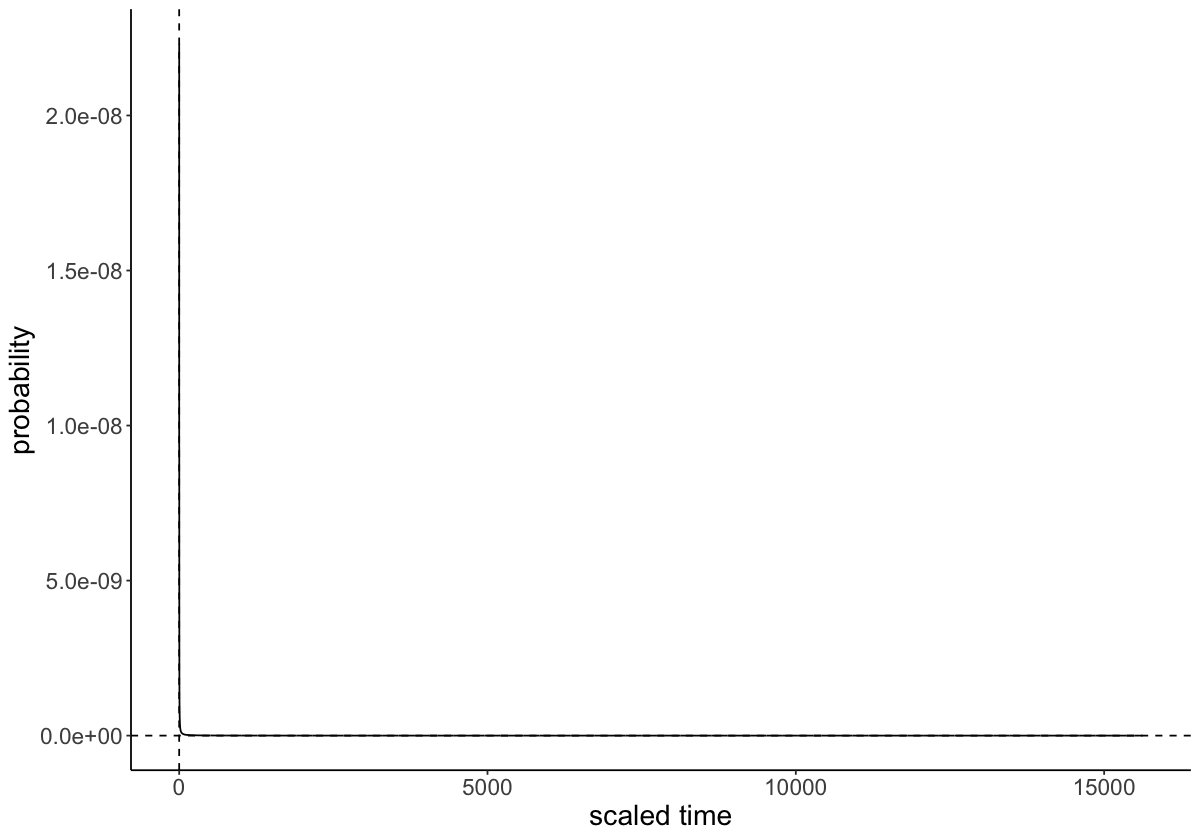

In [24]:
df %>% ggplot(aes(x=t, y=prob)) + 
    geom_line(color='black') + 
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_vline(xintercept = 0, linetype = "dashed") +
    labs(x='scaled time', y='probability') + 
    despine + scale_color_viridis(discrete = TRUE)

In [25]:
rewards

0,0,0,0,0,0,0,0,0,0,⋯,1,0,1,0,0,0,0,0,1,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,1,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,1,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [26]:
x <- lapply(df$t, back, base=base, state_length=nrow(rewards))
#x <- lapply(x, rev)
m <- do.call(rbind, x)
multi_df <- data.frame(m)
multi_df['prob'] = df$prob
head(multi_df)

,X1,X2,X3,X4,X5,X6,X7,X8,prob
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,2.231411e-08
2,1,0,0,0,0,0,0,0,9.302290e-09
3,2,0,0,0,0,0,0,0,4.340539e-09
4,3,0,0,0,0,0,0,0,2.376036e-09
5,4,0,0,0,0,0,0,0,1.538130e-09
6,0,0,0,0,0,0,0,0,1.134574e-09


In [27]:
tail(multi_df)

,X1,X2,X3,X4,X5,X6,X7,X8,prob
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15621,0,4,4,4,4,0,0,0,7.198649e-15
15622,1,4,4,4,4,0,0,0,7.196346e-15
15623,2,4,4,4,4,0,0,0,7.194043e-15
15624,3,4,4,4,4,0,0,0,7.191742e-15
15625,4,4,4,4,4,0,0,0,7.189441e-15
15626,0,0,0,0,0,0,0,0,7.187140e-15


**Sanity check:** the marginal summed probabilities should sum to the SFS.

In [28]:
sum(multi_df$prob) / mut_rate

[1] 6.181167

In [40]:
# for (ton in c('X1', 'X2', 'X3') )
i <- 0
for (ton in c('X1', 'X2', 'X3', 'X4', 'X5', 'X6') ) {
    i <- i + 1
    mean_tons <- sum(multi_df[ton] * multi_df$prob)
    cat(mean_tons / mut_rate, '\t', mean_tons / mut_rate * i, '\n')
}

7.270263 	 7.270263 
3.736924 	 7.473848 
1.818439 	 5.455317 
0.6692026 	 2.67681 
0.02306046 	 0.1153023 
0 	 0 


In [166]:
# plot_df <- multi_df %>% group_by(X3, X4) %>% summarise(joint_prob = sum(prob))# %>% filter(X3 > 0 & X4 > 0)
# head(plot_df)
plot_df <- multi_df %>% group_by(X3, X4) %>% summarise(joint_prob = sum(prob))
plot_df[,-ncol(plot_df)] <- lapply(plot_df[,-ncol(plot_df)], as.factor)
head(plot_df)

`summarise()` has grouped output by 'X3'. You can override using the `.groups` argument.


X3,X4,joint_prob
<fct>,<fct>,<dbl>
0,0,4.638544e-08
0,1,3.026544e-15
1,0,1.558540e-09
2,0,5.731767e-10
3,0,2.108589e-10
4,0,7.757027e-11


In [39]:
tail(plot_df)

X3,X4,joint_prob
<fct>,<fct>,<dbl>
9,4,3.938072e-14
9,5,3.563315e-14
9,6,3.224221e-14
9,7,2.917395e-14
9,8,2.639768e-14
9,9,2.388561e-14


In [40]:
ggplot(plot_df, aes(x=X1, y=X2)) +
    geom_tile(aes(fill = joint_prob)) + 
    geom_text(aes(label = round(joint_prob, 2))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(plot_df$joint_prob)) * c(-1, 1)
                    ) +
theme_minimal() +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

ERROR while rich displaying an object: Error in `geom_tile()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error:
! objekt 'X1' blev ikke fundet

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handl

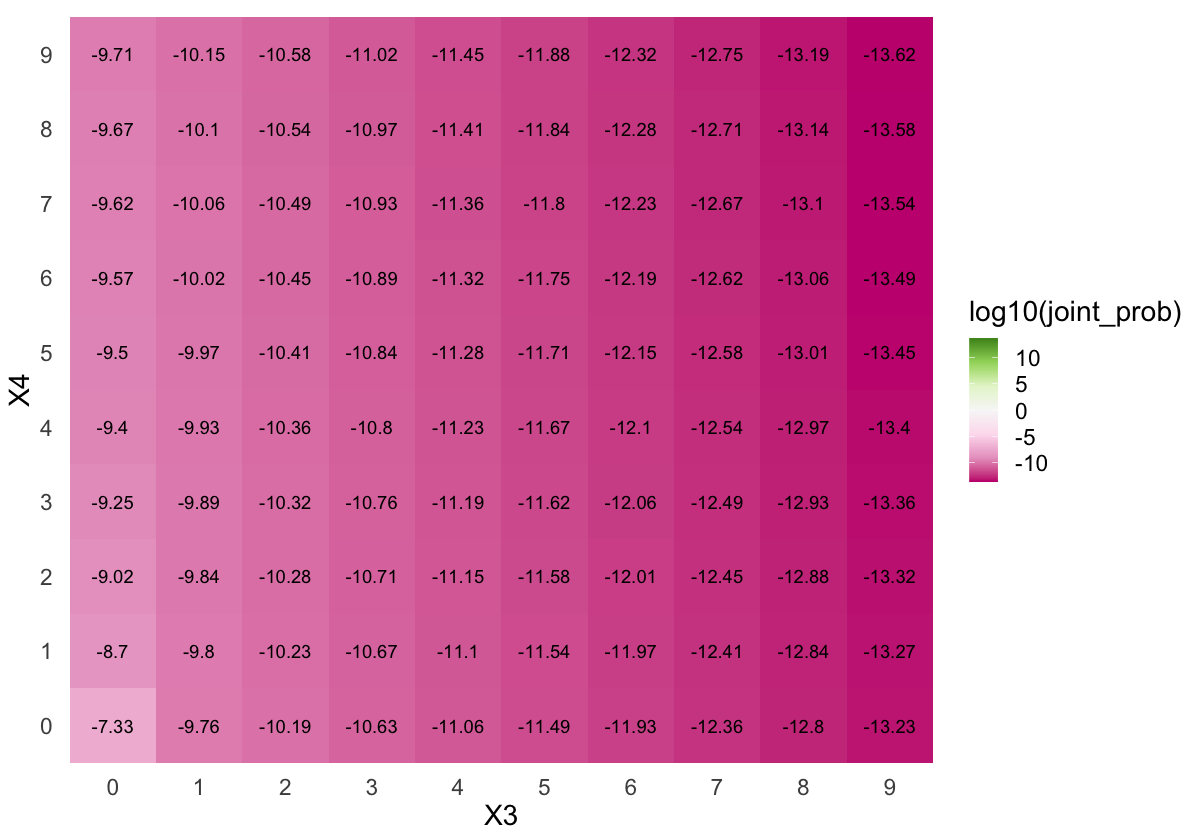

In [41]:
ggplot(plot_df, aes(x=X3, y=X4)) +
    geom_tile(aes(fill = log10(joint_prob))) + 
    geom_text(aes(label = round(log10(joint_prob), 2))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(log10(plot_df$joint_prob))) * c(-1, 1)
                    ) +
theme_minimal() +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))


In [232]:
x <- lapply(df$t, back, base=10, state_length=nrow(rewards))
x <- lapply(x, rev)
scalars <- c(1:sample_size, 0)
mask <- lapply(x, function(v) sum(v * scalars)) == sample_size
m <- do.call(rbind, x[mask])
m

4,0,0,0,0
2,1,0,0,0
0,2,0,0,0


In [ ]:
df[, df$t]

In [228]:
range <- seq(1, 100, 1)
x <- lapply(range, back, base=10, state_length=nrow(rewards))
x <- lapply(x, rev)
scalars <- c(1:sample_size, 0)
mask <- lapply(x, function(v) sum(v * scalars)) == sample_size
m <- do.call(rbind, x[mask])
m

4,0,0,0,0
2,1,0,0,0
0,2,0,0,0


In [230]:
valid_times <- range[mask]
df <- data.frame(t=valid_times)
df['prob'] <- sapply(valid_times, function (t) dph(t, g))
head(df)

,t,prob
,<dbl>,<dbl>
1,4,1.100381e-09
2,12,3.604568e-10
3,20,1.899179e-10


In [ ]:
t <- seq(from = 0, to = 5, by = 0.01)
fun <- function(t) {
    x <- stop_probability(graph, t)
    return(x[2:(length(x)-1)])
}
df <- as.data.frame(t(sapply(t, fun))) 
df['time'] <- t
head(df)

In [72]:
df <- data.frame(t=seq(1, 6, 0.001))
for (n in seq(2, 20))
{
    graph <- standard_coalescent(n)
    df[[n]] <- sapply(df$t, function (t) dph(t, graph))
}

Warning message:
“‘length(width)’ forskellig mellem ny og forrige
	 ==> NOT changing ‘width’”


ERROR: Error in as.character(x): cannot coerce type 'externalptr' to vector of type 'character'


---